In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from random import choice
import time
import operator
import networkx as nx
#import graphviz
import time
import copy

In [2]:
def createDictionary(size):
    dictionary = {}
    for i in range(size):
        dictionary[i] = i
    return dictionary

def plotGraph(G):
    plt.figure(figsize=(10,10))
    nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color='yellow', node_size=100, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edgeList=nx.edges(G), width=0.5, edge_color='green')
    nx.draw_networkx_labels(G, pos, createDictionary(G.number_of_nodes()), font_size=8)
    plt.show()

In [3]:
#return the cost of set all elements equal to the first of the sequence
def cost(d):
    return sum([d[0]-x for x in d])

In [4]:
#it takes a list of pairs as input and returns the index of the maximum value
def findMax(l):
    indexMax = 0
    valueMax = -1
    for i in range(0, len(l)):
        if l[i][1] > valueMax:
            indexMax = i
            valueMax = l[i][1]
    return indexMax

In [39]:
#sets all the elements of l equal to the first and computes the cost
def createEqualList(l):
    cost = 0
    for i in range(len(l)):
        cost += l[0] - l[i]
        l[i] = l[0]
    return cost, l

#d is the part of array to anonymize
def anonymizeRecGreedy(d, k):
    if len(d) < 2*k:
        return createEqualList(d)
    anonCost, anonList = createEqualList(d[0:k])
    if len(d) == 2*k:
        aux, newList = anonymizeRecGreedy(d[k:len(d)], k)
        anonList += newList
        anonCost += aux
        return anonCost, anonList
    for i in range(k, len(d)):
        mergeCost = d[0] - d[i] + cost(d[i+1:i+1+k])
        newCost = cost(d[i:i+k])
        if mergeCost > newCost:
            aux, newList = anonymizeRecGreedy(d[i:len(d)], k)
            anonList += newList
            anonCost += aux
            break
        else:
            anonCost += d[0] - d[i]
            anonList.append(d[0])
            if len(d) - i <= k:
                aux, newList = createEqualList(d[i+1:len(d)])
                anonList += newList
                anonCost += aux
                break
    return anonCost, anonList 

#anonymizes the degree sequence using the greedy algorithm
def anonymizeGreedy(d, k):
    return anonymizeRecGreedy(d,k)[1]
    

In [6]:
#input: the dictionary with pairs (node, residue)
#output: it tries to construct the new graph. if success it returns. if fails, it returns false
def try_graph(residueDict, G):
    while len(residueDict) > 1: #2 items needed
        u = choice(residueDict)
        residueDict.remove(u)
        respers=copy.deepcopy(residueDict)
        count = u[1]
        while count > 0:
            if len(respers) == 0:
                return False, _
            maxElem = findMax(respers)
            if(G.has_edge(u[0], respers[maxElem][0])):
                respers.remove(respers[maxElem])
                continue
            G.add_edge(u[0], respers[maxElem][0])
            for i in range(len(residueDict)):
                if(residueDict[i][0]==respers[maxElem][0]):
                    break
            if respers[maxElem][1] == 1:
                respers.remove(respers[maxElem])
                residueDict.remove(residueDict[i])
            else:
                respers[maxElem][1] -= 1
                residueDict[i][1] -= 1
            count -= 1
    return len(residueDict) == 0, G

def try_graph_multi(residueDict, G):
    while len(residueDict) > 1: #2 items needed
        u = choice(residueDict)
        residueDict.remove(u)
        count = u[1]
        while count > 0:
            if len(residueDict) == 0:
                #print("\n--------------------errore pazzesco--------------------\n", flush=True)
                return False, _
            maxElem = findMax(residueDict)
            G.add_edge(u[0], residueDict[maxElem][0])
            if residueDict[maxElem][1] == 1:
                residueDict.remove(residueDict[maxElem])
            else:
                residueDict[maxElem][1] -= 1
            count -= 1
    return len(residueDict) == 0, G

In [7]:
#add noise at the last element as +1
def addNoiseOld(degreeSequence):
    degreeSequence[len(degreeSequence)-1] += 1
    degreeSequence.sort(reverse = True)
    #print("old noise: " + str(degreeSequence))
    return degreeSequence

#input: degree sequence of graph (degree_dict), corresponding graph to anonymize, k
#output: the number of failure to construct the graph and the anonymized graph
def construct_graph_old(degree_dict, G, k, multi=False):
    counter = 0
    oldD = [x[1] for x in degree_dict]
    curD = oldD.copy()
    flag = False
    while not flag:
        counter += 1
        newD = anonymizeGreedy(curD, k)
        if sum(newD)%2 == 0:
            residueList = [a - b for a, b in zip(newD, oldD)]
            residueDict = []
            for y in range(len(residueList)):
                if residueList[y] > 0: #filtering node with residue equal to 0
                    residueDict.append([degree_dict[y][0], residueList[y]])
            residueDict = sorted(residueDict, key = lambda x:x[1], reverse=True)
            newGraph = G.copy()
            if not multi:
                flag, newGraph = try_graph(residueDict, newGraph)
            else:
                #print("errore pazzesco")
                flag, newGraph = try_graph_multi(residueDict, newGraph)
            if not flag: #failed attempt
                addNoiseOld(curD)
        else: #odd degree sequence
            addNoiseOld(curD)
    #print("counter " + str(counter))
    return counter, newGraph

In [8]:
preSequence = []
curSequence = []
alreadyFail = False
elem = 0

def addNoise(degreeSequence, k):
    #print("addNoise")
    #print("prima di aggiungere il rumore: " + str(degreeSequence))
    global preSequence
    global curSequence
    global alreadyFail
    global elem
    
    for i in range(len(curSequence)):
        if curSequence[i]!=preSequence[i]: #c'è stato un cambiamento tra i residui delle due sequenze
            print("c'è stato un cambiamento tra i residui delle due sequenze")
            degreeSequence[len(degreeSequence)-1]+=1 #aggiungo semplicemente 1 come noise
            degreeSequence.sort(reverse = True)
            preSequence = curSequence
            alreadyFail = False
            elem = 0
            print("dopo aver aggiunto il rumore: " + str(degreeSequence))
            return
    
    print("non c'è stato un cambiamento tra i residui delle due sequenze")
    
    #se esco dal for significa che non c'è stato un cambiamento tra i residui dal giro prima
    if not alreadyFail: #se è la prima volta che c'è un fallimento senza cambiamenti nelle sequenze dei residui
        print("prima volta che fallisco senza cambiamenti")
        alreadyFail = True
        elem = degreeSequence[len(degreeSequence)-1]
        degreeSequence[len(degreeSequence)-1]+=1
        degreeSequence.sort(reverse = True)
        preSequence = curSequence
        print("dopo aver aggiunto il rumore: " + str(degreeSequence))
        return
    
    #se arrivo a questo punto significa che non c'è stato un cambiamento nelle sequenze dei residui
    #e in più sono già fallito una volta
    if degreeSequence[len(degreeSequence)-1] != elem: #sono fallito con un nuovo elemento. quindi resetto tutto
        print("fallito per la seconda volta di seguito ma con due elementi diversi")
        print("elem precedente = " + str(elem) + " nuovo elem = " + str(degreeSequence[len(degreeSequence)-1]))
        degreeSequence[len(degreeSequence)-1]+=1 #aggiungo semplicemente 1 come noise
        degreeSequence.sort(reverse = True)
        preSequence = np.zeros(len(preSequence)) #questa operazione mi garantisce che al giro successivo, in caso di fallimento, verrà fatto un giro di noise normale
        alreadyFail = False
        elem = 0
        print("dopo aver aggiunto il rumore: " + str(degreeSequence))
        return
    
    #sono fallito più volte con lo stesso elemento
    print("fallito per la seconda volta di fila nuovamente con lo stesso elemento")
    count = 1 -k
    for i in range(len(degreeSequence)): #conto quanti elementi ho da pinzare
        if degreeSequence[i] == elem:
            count += 1
    print("devo pinzare " + str(count) + " elementi con valore " + str(elem))
    #i = len(degreeSequence)-1
    while count > 0:
        print("metto al posto di " + str(degreeSequence[len(degreeSequence)-count]) + " l'elemento " + str(elem+1))
        degreeSequence[len(degreeSequence)-count] = elem + 1
        count-=1
        
    degreeSequence.sort(reverse = True)
    preSequence = np.zeros(len(preSequence))
    alreadyFail = False
    elem = 0
    print("dopo aver aggiunto il rumore: " + str(degreeSequence))
    return
            
#input: degree sequence of graph (degree_dict), corresponding graph to anonymize, k
#output: the number of failure to construct the graph and the anonymized graph
def construct_graph(degree_dict, G, k, multi=False):
    global preSequence
    global curSequence
    preSequence = np.zeros(len(degree_dict))
    counter = 0
    oldD = [x[1] for x in degree_dict]
    curD = oldD.copy()
    flag = False
    firstTime = True
    while not flag:
        counter += 1
        newD = anonymizeGreedy(curD, k)
        residueList = [a - b for a, b in zip(newD, oldD)]
        curSequence = residueList
        if sum(newD)%2 == 0:
            residueDict = []
            for y in range(len(residueList)):
                if residueList[y] > 0: #filtering node with residue equal to 0
                    residueDict.append([degree_dict[y][0], residueList[y]])
            residueDict = sorted(residueDict, key = lambda x:x[1], reverse=True)
            newGraph = G.copy()
            if not multi:
                flag, newGraph = try_graph(residueDict, newGraph)
            else:
                #print("errore pazzesco")
                flag, newGraph = try_graph_multi(residueDict, newGraph)
            if not flag: #failed attempt
                addNoise(curD, k)
        else: #odd degree sequence
            addNoise(curD, k)
    #print("counter " + str(counter))
    return counter, newGraph

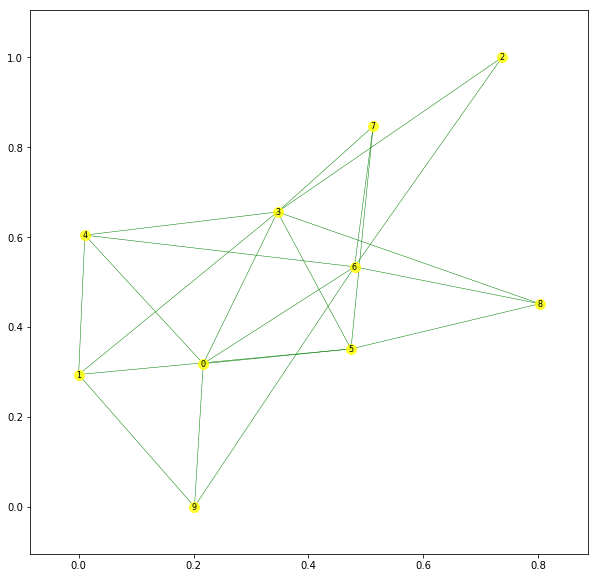

In [32]:
H = nx.barabasi_albert_graph(10, 3)
G = nx.MultiGraph()
G.add_nodes_from(H)
G.add_edges_from(H.edges())
pos=nx.spring_layout(G)
plotGraph(G)

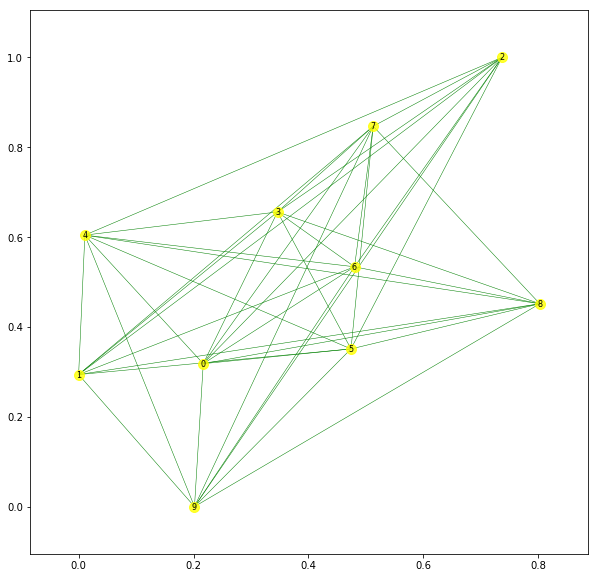



--- 0.3540785312652588 seconds ---
d non anonimizzata: [7, 6, 5, 5, 4, 4, 3, 3, 3, 2]
d anonimizzata: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]


In [33]:
sorted_x = sorted(G.degree().items(), key=operator.itemgetter(1), reverse=True)
start_time = time.time()
_,newGraph = construct_graph(sorted_x, G, 3)
plotGraph(newGraph)
print("\n\n--- %s seconds ---" % (time.time() - start_time))
print("d non anonimizzata: " + str(sorted(list(G.degree().values()), reverse=True)))
print("d anonimizzata: " + str(sorted(list(newGraph.degree().values()), reverse=True)))

In [52]:
A = nx.drawing.nx_agraph.to_agraph(newGraph)
A.add_subgraph()
A.draw('testsingle.png', prog='dot')

test 0
n 100
n 200
n 400
n 800
n 1600
n 3200
n 6400
test 1
n 100
n 200
n 400
n 800
n 1600
n 3200
n 6400


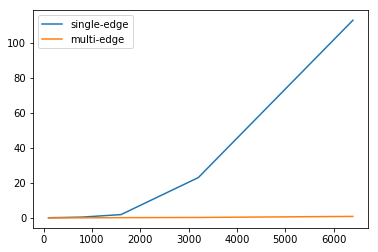

In [27]:
#Differences between execution time of the two algorithm (multi/single edge)
X=[100, 200, 400, 800, 1600, 3200, 6400]
y=np.zeros(len(X))
ymulti=np.zeros(len(X))
test=2
for j in range(test):
    print("test "+str(j))
    y2=[]
    y2multi=[]
    for i in X:  
        print("n "+str(i))
        H = nx.barabasi_albert_graph(i, 3)
        G = nx.MultiGraph()
        G.add_nodes_from(H)
        G.add_edges_from(H.edges())
        sorted_x = sorted(G.degree().items(), key=operator.itemgetter(1), reverse=True) 
        start_time = time.time()
        _,newGraph = construct_graph(sorted_x, G, 3, False)
        y1=time.time() - start_time
        y2.append(y1)
        start_time = time.time()
        newGraph = construct_graph(sorted_x, G, 3, True)
        y1=time.time() - start_time
        y2multi.append(y1)
    y+=y2
    ymulti+=y2multi
y=y/test
ymulti=ymulti/test
plt.plot(X,y,label='single-edge')
plt.plot(X,ymulti, label='multi-edge')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#how excecution time change with different K
K = np.linspace(1,20,10,dtype=int)
y = np.zeros(len(K))
C = np.zeros(len(K))
yOld = np.zeros(len(K))
COld = np.zeros(len(K))
test = 10
for i in range(test):
    G = nx.barabasi_albert_graph(1000, 3)
    sorted_x1 = sorted(G.degree().items(), key=operator.itemgetter(1), reverse=True)
    for j in range(len(K)):
        start_time = time.time()
        counter, newGraph = construct_graph(sorted_x1, G, K[j])
        d1 = newGraph.degree().items()
        y[j] += time.time() - start_time
        C[j] += counter
        start_time = time.time()
        counter, newGraph = construct_graph_old(sorted_x1, G, K[j])
        d2 = newGraph.degree().items()
        yOld[j] += time.time() - start_time
        COld[j] += counter
        print("k=" + str(K[j]))
        print("old: time=" + str(yOld[j]) + " failures=" + str(COld[j]))
        print("new: time=" + str(y[j]) + " failures=" + str(C[j]))
        print("differences=" + str(sum([a[1] - b[1] for a, b in zip(d1, d2)])))
y = y/test
C = C/test
yOld = yOld/test
COld = COld/test
plt.plot(K, y, label='new')
plt.plot(K, yOld, label='old')
plt.xlabel("K")
plt.ylabel("Time(s)")
plt.show()
plt.plot(K, C,label='new')
plt.plot(K, COld, label='old')
plt.xlabel("K")
plt.ylabel("Fails on construct graph")
plt.show()
print("ratio: "+str(sum(yOld)/sum(y)))

In [42]:
print("ratio: "+str(sum(yOld)/sum(y)))

ratio: 20.4107079536


[ 1  3  5  7  9 11 13 15 17 20]
test 0
K 1
K 3
K 5
K 7
K 9
K 11
K 13
K 15
K 17
K 20
test 1
K 1
K 3
K 5
K 7
K 9
K 11
K 13
K 15
K 17
K 20


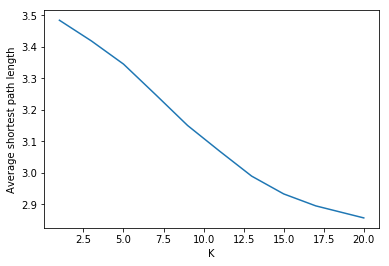

In [17]:
#how average_shortest_path_length time change with different K
K=np.linspace(1,20,10,dtype=int)
print(K)
y=np.zeros(len(K))
test=2

for j in range(test):
    G = nx.barabasi_albert_graph(1000, 3)
    print("test "+str(j))
    for i in range(len(K)): 
        print("K "+str(K[i]))
        sorted_x = sorted(G.degree().items(), key=operator.itemgetter(1), reverse=True)
        _,newGraph = construct_graph(sorted_x, G, K[i])
        y1=nx.average_shortest_path_length(newGraph)
        y[i]+=y1
y=y/test
plt.plot(K,y)
plt.ylabel('Average shortest path length')
plt.xlabel('K')
plt.show()

[ 1  3  5  7  9 11 13 15 17 20]
test 0
K 1
K 3
K 5
K 7
K 9
K 11
K 13
K 15
K 17
K 20
test 1
K 1
K 3
K 5
K 7
K 9
K 11
K 13
K 15
K 17
K 20


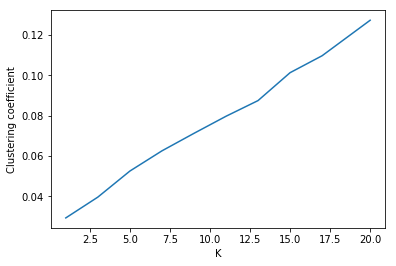

In [18]:
#how clustering coefficient change with different K
K=np.linspace(1,20,10,dtype=int)
print(K)
y=np.zeros(len(K))
test=2

for j in range(test):
    G = nx.barabasi_albert_graph(1000, 3)
    print("test "+str(j))
    for i in range(len(K)): 
        print("K "+str(K[i]))
        sorted_x = sorted(G.degree().items(), key=operator.itemgetter(1), reverse=True)
        _,newGraph = construct_graph(sorted_x, G, K[i])
        y1=nx.average_clustering(newGraph)
        y[i]+=y1
y=y/test
plt.plot(K,y)
plt.ylabel('Clustering coefficient')
plt.xlabel('K')
plt.show()


degree sequence at start: [8, 8, 4, 4, 4, 4, 3, 3, 3, 1]
k=3
old: time=0.00199770927429 failures=12.0
new: time=0.00300002098083 failures=16.0
differences=6
d1: [8, 8, 8, 8, 5, 5, 5, 5, 5, 5]
d2: [8, 8, 8, 5, 5, 5, 5, 4, 4, 4]

degree sequence at start: [7, 7, 5, 4, 4, 3, 3, 3, 3, 3]
k=3
old: time=0.00199770927429 failures=15.0
new: time=0.00399851799011 failures=19.0
differences=0
d1: [7, 7, 7, 4, 4, 4, 4, 3, 3, 3]
d2: [7, 7, 7, 4, 4, 4, 4, 3, 3, 3]

degree sequence at start: [6, 6, 6, 5, 4, 4, 3, 3, 3, 2]
k=3
old: time=0.00301074981689 failures=19.0
new: time=0.00399851799011 failures=23.0
differences=0
d1: [6, 6, 6, 6, 4, 4, 4, 4, 4, 4]
d2: [6, 6, 6, 6, 4, 4, 4, 4, 4, 4]

degree sequence at start: [7, 7, 5, 4, 4, 4, 3, 3, 3, 2]
k=3
old: time=0.00301074981689 failures=26.0
new: time=0.00499820709229 failures=31.0
differences=0
d1: [7, 7, 7, 5, 5, 5, 4, 4, 4, 4]
d2: [7, 7, 7, 7, 4, 4, 4, 4, 4, 4]

degree sequence at start: [7, 7, 5, 4, 4, 4, 3, 3, 3, 2]
k=3
old: time=0.00301074981689

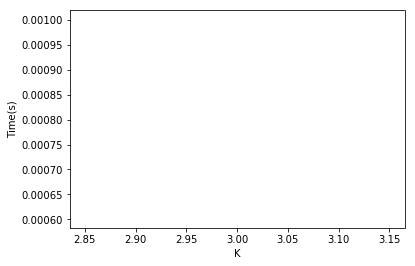

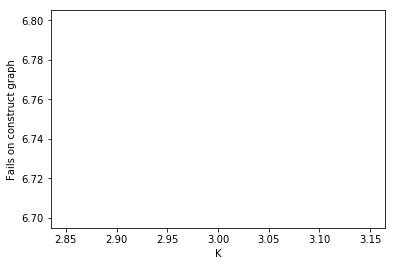

ratio: 0.603690265909


In [42]:
#how excecution time change with different K
#K = np.linspace(1,20,10,dtype=int)
K = [3]
y = np.zeros(len(K))
C = np.zeros(len(K))
yOld = np.zeros(len(K))
COld = np.zeros(len(K))
test = 10
for i in range(test):
    G = nx.barabasi_albert_graph(10, 3)
    sorted_x1 = sorted(G.degree().items(), key=operator.itemgetter(1), reverse=True)
    print("\ndegree sequence at start: " + str([x[1] for x in sorted_x1]))
    for j in range(len(K)):
        print("k=" + str(K[j]))
        start_time = time.time()
        counter, newGraph = construct_graph(sorted_x1, G, K[j])
        d1 = sorted(newGraph.degree().items(), key=operator.itemgetter(1), reverse=True)
        y[j] += time.time() - start_time
        C[j] += counter
        start_time = time.time()
        counter, newGraph = construct_graph_old(sorted_x1, G, K[j])
        d2 = sorted(newGraph.degree().items(), key=operator.itemgetter(1), reverse=True)
        yOld[j] += time.time() - start_time
        COld[j] += counter
        print("old: time=" + str(yOld[j]) + " failures=" + str(COld[j]))
        print("new: time=" + str(y[j]) + " failures=" + str(C[j]))
        print("differences=" + str(sum([a[1] - b[1] for a, b in zip(d1, d2)])))
        print("d1: " + str([x[1] for x in d1]))
        print("d2: " + str([x[1] for x in d2]))


y = y/test
C = C/test
yOld = yOld/test
COld = COld/test
plt.plot(K, y, label='new')
plt.plot(K, yOld, label='old')
plt.xlabel("K")
plt.ylabel("Time(s)")
plt.show()
plt.plot(K, C,label='new')
plt.plot(K, COld, label='old')
plt.xlabel("K")
plt.ylabel("Fails on construct graph")
plt.show()
print("ratio: "+str(sum(yOld)/sum(y)))

In [43]:
#how excecution time change with different K
#K = np.linspace(1,20,10,dtype=int)
K = [5]
y = np.zeros(len(K))

test = 10
G = nx.barabasi_albert_graph(1000, 3)
sorted_x1 = sorted(G.degree().items(), key=operator.itemgetter(1), reverse=True)
#print("degree sequence at start: " + str([x[1] for x in sorted_x1]))

for i in range(test):
    for j in range(len(K)):
        print("\n\nk=" + str(K[j]))
        counter, newGraph = construct_graph(sorted_x1, G, K[j])
        d1 = sorted(newGraph.degree().items(), key=operator.itemgetter(1), reverse=True)
        counter, newGraph = construct_graph_old(sorted_x1, G, K[j])
        d2 = sorted(newGraph.degree().items(), key=operator.itemgetter(1), reverse=True)
        y[j]+=sum([a[1] - b[1] for a, b in zip(d1, d2)])
        print("difference=" + str(sum([a[1] - b[1] for a, b in zip(d1, d2)])))
        print("y[j]=" + str(y[j]))
print("\nfine\n" + str(y))



k=5
difference=2
y[j]=2.0


k=5
difference=0
y[j]=2.0


k=5
difference=0
y[j]=2.0


k=5
difference=2
y[j]=4.0


k=5
difference=0
y[j]=4.0


k=5
difference=0
y[j]=4.0


k=5
difference=0
y[j]=4.0


k=5
difference=0
y[j]=4.0


k=5
difference=0
y[j]=4.0


k=5
difference=0
y[j]=4.0

fine
[ 4.]


In [40]:
sorted_x1 = sorted(G.degree().items(), key=operator.itemgetter(1), reverse=True)
print("\ndegree sequence at start: " + str([x[1] for x in sorted_x1]))
counter, newGraph = construct_graph(sorted_x1, G, K[j])
d1 = sorted(newGraph.degree().items(), key=operator.itemgetter(1), reverse=True)
print("d1: " + str([x[1] for x in d1]))


degree sequence at start: [7, 6, 6, 5, 4, 4, 3, 3, 3, 1]
d1: [7, 7, 7, 7, 4, 4, 4, 4, 4, 4]


In [38]:
#return the cost of set all elements equal to the first of the sequence
def cost(d):
    return sum([d[0]-x for x in d])

print(cost([7, 6, 6]))
print(cost([5, 4, 4]))

2
2
